# Analyze Model Behvaiour of 3D Segmentation

Consider to download this Jupyter Notebook and run locally, or test it with Colab.
<br>
[![Download](https://img.shields.io/badge/Download-jupyter-blue)](https://github.com/ZerojumpLine/MOVAL/blob/main/docs/source/demos/analysis_seg3d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1_jU3umIceF-QyT25fI9G9BpK21es_2Wu#scrollTo=b04a1cbe-baeb-4fa9-8644-c73eb4d1ea98)

* In this notebook, we will show how to analyze the model behaviour based using MOVAL for 3D segmentation tasks.
<br>
* More specifically, we show an example of analyzing model behaviour under domain shifts on Prostate MRI segmentation based on a 3D U-Net. We will utilize the calculated logits on test dataset acquired with a different scanner.
<br>
* We will visualize the calibrated confidence scores as an proper indication of missegmentation.

In [100]:
!pip install moval
!pip install seaborn
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install nibabel
!pip install scikit-image

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 4.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 5.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.9/220.9 kB 4.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 5.5 MB/s eta 0:00:00a 0:00:01


In [101]:
import os
import gdown
import itertools
import zipfile
import pandas as pd
import numpy as np
import nibabel as nib
import moval
from moval.solvers.utils import ComputMetric
from tqdm import tqdm
import seaborn as sns
from skimage.transform import resize
import matplotlib.pyplot as plt

In [4]:
print(f"The installed MOVAL verision is {moval.__version__}")

The installed MOVAL verision is 0.1.16


## Load the data

In [5]:
# download the data, which we used for MICCAI 2022

output = "data_moval.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=139pqxkG2ccIFq6qNArnFJWQ2by2Spbxt&export=download"
    output = "data_moval.zip"
    gdown.download(url, output, quiet=False)

directory_data = "data_moval"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [7]:
# download the coresponding image data

output = "img_prostate.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=1_zfIZ6aM6X3qtFjpO1BiYS7LKBxpfJ_r&export=download"
    output = "img_prostate.zip"
    gdown.download(url, output, quiet=False)

directory_data = "img_prostate"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

Downloading...
From (uriginal): https://drive.google.com/u/0/uc?id=1_zfIZ6aM6X3qtFjpO1BiYS7LKBxpfJ_r&export=download
From (redirected): https://drive.google.com/uc?id=1_zfIZ6aM6X3qtFjpO1BiYS7LKBxpfJ_r&export=download&confirm=t&uuid=137ee6c9-a608-4f2c-af53-699bc9c4a272
To: /Users/zejuli/Local/Imperial/MOVAL/docs/source/demos/img_prostate.zip
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 37.8M/37.8M [00:07<00:00, 5.39MB/s]


In [9]:
ls

analysis_cls.ipynb    data_moval_supp.zip   img_cifar/
analysis_seg2d.ipynb  estim_cls.ipynb       img_cifar.zip
analysis_seg3d.ipynb  estim_seg2d.ipynb     img_prostate/
data_moval/           estim_seg3d.ipynb     img_prostate.zip
data_moval.zip        img_cardiac/
data_moval_supp/      img_cardiac.zip


In [102]:
# now I am playing with prostate segmentation
Datafile_eval = "data_moval/Prostateresults/seg-eval.txt"
Imglist_eval = open(Datafile_eval)
Imglist_eval_read = Imglist_eval.read().splitlines()

logits = []
gt = []
# to accelerate the debugging speed, crop the middel 60 x 60 x 30 cub for training/inference.
for Imgname_eval in Imglist_eval_read:
    GT_file = Imgname_eval.replace("data", "data_moval")
    caseID = Imgname_eval.split("/")[-1][:6]
    logit_cls0_file = "data_moval/Prostateresults/prostateval/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval/Prostateresults/prostateval/results/pred_" + caseID + "cls1_prob.nii.gz"
    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls0      = logit_cls0_read.get_fdata()   # ``(H, W, D)``
    logit_cls1      = logit_cls1_read.get_fdata()
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H, W, D)``
    logit_cls0      = logit_cls0[logit_cls0.shape[0] //2 - 30: logit_cls0.shape[0] //2 + 30,
                                 logit_cls0.shape[1] //2 - 30: logit_cls0.shape[1] //2 + 30,
                                 logit_cls0.shape[2] //2 - 15: logit_cls0.shape[2] //2 + 15]
    logit_cls1      = logit_cls1[logit_cls1.shape[0] //2 - 30: logit_cls1.shape[0] //2 + 30,
                                 logit_cls1.shape[1] //2 - 30: logit_cls1.shape[1] //2 + 30,
                                 logit_cls1.shape[2] //2 - 15: logit_cls1.shape[2] //2 + 15]
    GTimg           = GTimg[GTimg.shape[0] //2 - 30: GTimg.shape[0] //2 + 30,
                            GTimg.shape[1] //2 - 30: GTimg.shape[1] //2 + 30,
                            GTimg.shape[2] //2 - 15: GTimg.shape[2] //2 + 15]
    logit_cls = np.stack((logit_cls0, logit_cls1))  # ``(d, H, W, D)``
    logits.append(logit_cls)
    gt.append(GTimg)

# logits is a list of length ``n``,  each element has ``(d, H, W, D)``. 
# gt is a list of length ``n``,  each element has ``(H, W, D)``.
# H, W and D could differ for different cases.

Datafile_test = "data_moval/Prostateresults/seg-testA.txt"
Imglist_test = open(Datafile_test)
Imglist_test_read = Imglist_test.read().splitlines()

logits_test = []
gt_test = []
imgs_test = []
for Imgname_test in Imglist_test_read:
    GT_file = Imgname_test.replace("data", "data_moval")

    caseID = Imgname_test.split("/")[-1][:6]

    logit_cls0_file = "data_moval/Prostateresults/prostattestcondition_A/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval/Prostateresults/prostattestcondition_A/results/pred_" + caseID + "cls1_prob.nii.gz"

    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls0      = logit_cls0_read.get_fdata()
    logit_cls1      = logit_cls1_read.get_fdata()
   
    img_file = f"img_prostate/img_prostate/test/{caseID}/image.nii.gz"
    img_read = nib.load(img_file)
    img_data      = img_read.get_fdata()   # ``(H, W, D)``
    
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H', W', D')``

    img_data = resize(img_data, GTimg.shape, mode='constant')
    logit_cls = np.stack((logit_cls0, logit_cls1))  # ``(n', H', W', D')``
    
    logits_test.append(logit_cls)
    gt_test.append(GTimg)
    imgs_test.append(img_data)


# logits_test is a list of length ``n'``,  each element has ``(d, H', W', D')``. 
# gt_test is a list of length ``n'``,  each element has ``(H', W', D')``.
# H, W and D could differ for different cases.

In [103]:
print(f"The validation predictions, ``logits`` are a list of length {len(logits)} each element has approximately {logits[0].shape}")
print(f"The validation labels, ``gt`` are a list of length {len(gt)}, each element has approximately {gt[0].shape}\n")
print(f"The test predictions, ``logits_test`` are a list of length {len(logits_test)} each element has approximately {logits_test[0].shape}")
print(f"The test labels, ``gt_test`` are a list of length {len(gt_test)}, each element has approximately {gt_test[0].shape}")
print(f"The test images, ``imgs_test`` are a list of length {len(imgs_test)}, each element has approximately {imgs_test[0].shape}")

The validation predictions, ``logits`` are a list of length 10 each element has approximately (2, 60, 60, 30)
The validation labels, ``gt`` are a list of length 10, each element has approximately (60, 60, 30)

The test predictions, ``logits_test`` are a list of length 2 each element has approximately (2, 256, 256, 40)
The test labels, ``gt_test`` are a list of length 2, each element has approximately (256, 256, 40)
The test images, ``imgs_test`` are a list of length 2, each element has approximately (256, 256, 40)


## MOVAL estimataion

In [19]:
moval_options = []
moval_options.append(['ac-model', 'segmentation', 'max_class_probability-conf', False])
moval_options.append(['ts-model', 'segmentation', 'max_class_probability-conf', False])
moval_options.append(['ts-model', 'segmentation', 'max_class_probability-conf', True])
moval_options.append(['ts-atc-model', 'segmentation', 'entropy-conf', True])

In [20]:
def test_cls(estim_algorithm, mode, confidence_scores, class_specific, logits, gt, logits_tests, gt_tests):
    """Test MOVAL with different conditions for segmentation tasks
        
    Args:
        mode (str): The given task to estimate model performance.
        confidence_scores (str):
            The method to calculate the confidence scores. We provide a list of confidence score calculation methods which 
            can be displayed by running :py:func:`moval.models.get_conf_options`.
        estim_algorithm (str):
            The algorithm to estimate model performance. We also provide a list of estimation algorithm which can be displayed by
            running :py:func:`moval.models.get_estim_options`.
        class_specific (bool):
            If ``True``, the calculation will match class-wise confidence to class-wise accuracy.
        logits: The network output (logits) of a list of n ``(d, H, W, (D))`` for segmentation. 
        gt: The cooresponding annotation of a list of n ``(H, W, (D))`` for segmentation.
        logits_tests:  The network testing output (logits) of a list of n' ``(d, H', W', (D'))`` for segmentation. 
        gt_test: The cooresponding testing annotation of a list of n' ``(H', W', (D'))`` for segmentation.

    Returns:
        err_test (float): testing error.
        moval_model: Optimized moval model.

    """
    
    moval_model = moval.MOVAL(
                mode = mode,
                confidence_scores = confidence_scores,
                estim_algorithm = estim_algorithm,
                class_specific = class_specific,
                approximate = True,
                approximate_boundary = 10
                )

    #
    moval_model.fit(logits, gt)

    # save the test err in the result files.

    estim_dsc_test = moval_model.estimate(logits_test)

    return moval_model

In [22]:
moval_model_MCP = test_cls(
        estim_algorithm = moval_options[0][0], 
        mode = moval_options[0][1], 
        confidence_scores = moval_options[0][2],
        class_specific = moval_options[0][3],
        logits = logits,
        gt = gt,
        logits_tests = logits_test,
        gt_tests = gt_test
    )
#
moval_model_baseline = test_cls(
        estim_algorithm = moval_options[1][0], 
        mode = moval_options[1][1], 
        confidence_scores = moval_options[1][2],
        class_specific = moval_options[1][3],
        logits = logits,
        gt = gt,
        logits_tests = logits_test,
        gt_tests = gt_test
    )
#
moval_model_cs = test_cls(
        estim_algorithm = moval_options[2][0], 
        mode = moval_options[2][1], 
        confidence_scores = moval_options[2][2],
        class_specific = moval_options[2][3],
        logits = logits,
        gt = gt,
        logits_tests = logits_test,
        gt_tests = gt_test
    )
#
moval_model_cs_entropy = test_cls(
        estim_algorithm = moval_options[3][0], 
        mode = moval_options[3][1], 
        confidence_scores = moval_options[3][2],
        class_specific = moval_options[3][3],
        logits = logits,
        gt = gt,
        logits_tests = logits_test,
        gt_tests = gt_test
    )

Starting optimizing for model ac-model with confidence max_class_probability-conf, class specific is False.
Starting optimizing for model ts-model with confidence max_class_probability-conf, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model ts-model with confidence max_class_probability-conf, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Not satisfied with initial optimization results of param, trying more initial states...
Tried 1/2 times.
Tried 2/2 times.
Starting optimizing for model ts-atc-model with confidence entropy-conf, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...


## Get the confidence scores

In [72]:
conf_mcp = moval_model_MCP.model_.calibrate(logits_test) # n list of (H, W, D)
conf_baseline = moval_model_baseline.model_.calibrate(logits_test)  # n list of (H, W, D)
conf_cs = moval_model_cs.model_.calibrate(logits_test)  # n list of (H, W, D)
conf_cs_entropy = moval_model_cs_entropy.model_.calibrate(logits_test)  # n list of (H, W, D)

In [107]:
conf_mcp_0 = 1-conf_mcp[0]
img_toshow = imgs_test[0][:,:,20]

In [131]:
img_toshow = (img_toshow - np.min(img_toshow)) / (np.max(img_toshow) - np.min(img_toshow))

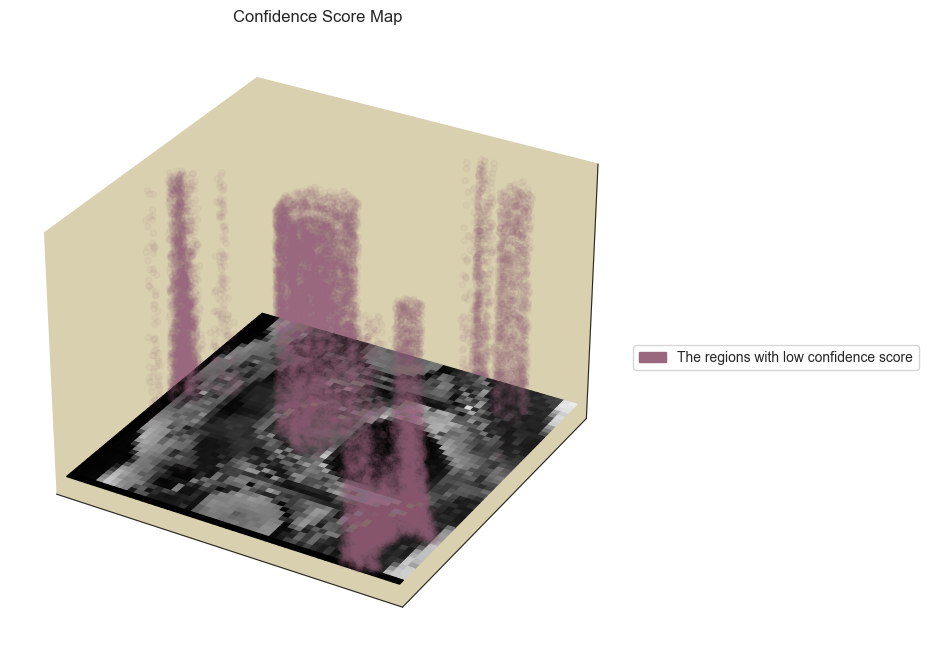

In [185]:
# Set up the 3D plot
sns.set_style("white")
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define a threshold for filtering out small values
threshold = 0.1  # Adjust as needed

# Plot each 2D scatter plot as a separate layer
for i in range(conf_mcp_0.shape[2]):
    x, y = np.meshgrid(np.arange(conf_mcp_0.shape[0]), np.arange(conf_mcp_0.shape[1]))
    z = conf_mcp_0[:, :, i]

    # Filter out small values
    mask = z > threshold
    x = x[mask]
    y = y[mask]
    z = z[mask]

    ax.scatter(x, y, z, c='#99687f', alpha=0.05)

# Get the maximum z value from the scatter plot
max_z_scatter = np.min(z)

# Show the image on the bottom x-y plane
x, y = np.meshgrid(np.arange(img_toshow.shape[0]), np.arange(img_toshow.shape[1]))
ax.plot_surface(x, y, max_z_scatter * np.ones_like(img_toshow), facecolors=plt.cm.gray(img_toshow), rstride=5, cstride=5, shade=False)

# Remove tick lines and labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])


ax.set_title('Confidence Score Map')

ax.set_xlim(0, 255)
ax.set_ylim(0, 255)

import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='#99687f', label='The regions with low confidence score')
plt.legend(handles=[blue_patch], bbox_to_anchor=(1, 0.5), loc='upper left')

ax.xaxis.set_pane_color('#d9d0af')
ax.yaxis.set_pane_color('#d9d0af')
ax.zaxis.set_pane_color('#d9d0af')

ax.grid(False)

# Show the plot
plt.show()